# Statistical analysis

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed.csv"
d = pd.read_csv(datafilename)
#d = d[-72:] # use just the data for the  last participant

print("Loading", len(d), "lines.")

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 12600 lines.


## Participants

In [3]:
TPP = 72  # there are 72 trials per participant
TPT = 36  # there are 36 trials per test
TPL = 20  # there are 20 trials per lexical test

for sid in [1, 2]:
    dt = d[d["Study ID"] == sid]
    if not dt.empty:
        print()
        print()
        print("## Counts for study ID:", sid)
        print()
        print("Number of participants:")
        print(len(dt) / TPP) 
        print()
        print("Fluent vs. non-fluent:")
        display(pd.DataFrame(dt["Fluent"].value_counts() / TPP))
        print()
        print("Different kinds of designers and which font was first:")
        
        dtt = pd.DataFrame(columns=["Designer", "Non-designer", "total"], index=["sansforgetica", "arial", "total"])
        dtt["Designer"] = dt[(dt["Test ID"] == 1) & (dt["Test type"] == "lexical") & (dt["Designer"] != "Non-designer")]["Font"].value_counts()
        dtt["Non-designer"] = dt[(dt["Test ID"] == 1) & (dt["Test type"] == "lexical") & (dt["Designer"] == "Non-designer")]["Font"].value_counts()
        dtt /=  TPL
        dtt["total"] = dtt.T.sum()
        dtt.loc["total"] = dtt.sum()
        display(dtt)
        print()
        display(pd.DataFrame(dt["Designer"].value_counts() / TPP))

        print("JoM for categories of designers:")
        display(pd.DataFrame(dt.groupby("Designer")["JoM"].mean()))
        print()
        print("JoL for categories of designers:")
        display(pd.DataFrame(dt.groupby("Designer")["JoL"].value_counts() / TPT))





## Counts for study ID: 1

Number of participants:
92.0

Fluent vs. non-fluent:


,Fluent
True,87.0
False,5.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,26.0,21.0,47.0
arial,23.0,22.0,45.0
total,49.0,43.0,92.0


,Designer
Non-designer,43.0
Letter designer,25.0
Graphic designer,13.0
Other designer,6.0
Typographer,5.0


JoM for categories of designers:


,JoM
Designer,
Graphic designer,57.384615
Letter designer,55.160000
Non-designer,55.139535
Other designer,49.166667
Typographer,61.000000



JoL for categories of designers:


JoL
Designer         JoL                         
Graphic designer very easy to read       12.0
                 ok                       8.0
                 easy to read             3.0
                 very difficult to read   2.0
                 difficult to read        1.0
Letter designer  very easy to read       14.0
                 difficult to read       13.0
                 ok                      11.0
                 easy to read             9.0
                 very difficult to read   3.0
Non-designer     very easy to read       38.0
                 ok                      22.0
                 difficult to read       13.0
                 easy to read            11.0
                 very difficult to read   2.0
Other designer   very easy to read        5.0
                 ok                       4.0
                 difficult to read        2.0
                 very difficult to read   1.0
Typographer      very easy to read        4.0
                 difficult to read        3.0
                 ok                       2.0
                 easy to read             1.0



## Counts for study ID: 2

Number of participants:
83.0

Fluent vs. non-fluent:


,Fluent
True,79.0
False,4.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,22.0,22.0,44.0
arial,17.0,22.0,39.0
total,39.0,44.0,83.0


,Designer
Non-designer,44.0
Graphic designer,15.0
Letter designer,15.0
Typographer,6.0
Other designer,3.0


JoM for categories of designers:


,JoM
Designer,
Graphic designer,49.566667
Letter designer,58.366667
Non-designer,51.204545
Other designer,48.666667
Typographer,52.166667



JoL for categories of designers:


JoL
Designer         JoL                         
Graphic designer very easy to read       14.0
                 difficult to read        7.0
                 easy to read             5.0
                 ok                       4.0
Letter designer  difficult to read       12.0
                 easy to read             7.0
                 very easy to read        6.0
                 ok                       4.0
                 very difficult to read   1.0
Non-designer     very easy to read       39.0
                 ok                      19.0
                 difficult to read       14.0
                 easy to read            10.0
                 very difficult to read   6.0
Other designer   difficult to read        3.0
                 easy to read             2.0
                 very easy to read        1.0
Typographer      ok                       6.0
                 easy to read             3.0
                 very easy to read        3.0

## Calculating AUC and RT

In [4]:

map_JoL = {
    "very easy to read": 100,
    "easy to read": 75,
    "ok": 50,
    "difficult to read": 25,
    "very difficult to read": 0,
}

def get_agg_results(d):
    """
    Aggregate data for every (study, test, participant) combination.
    Calculate AUC and RT across all of their relevant responses
    (originally 36 trials, but could be less after outliers were removed)
    and average them for: all, words,  and non-words.
    """

    # prepare empty results DataFrame
    # aggregate correct and response time (use mean value)
    # the rest is either copied or new (NaN value)
    result_columns = ["Study ID", "Participant ID", "Test ID", "Test type",
                      "Fluent", "Designer", "isDesigner", "Font", "Correct", "Response time",
                      "Response time (word)", "Response time (non-word)",
                      "AUC", "AUC (word)", "AUC (non-word)",
                      "JoL", "JoM", "Date"]
    agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
    agg_columns["Correct"] = "mean"
    agg_columns["Response time"] = "mean"
    results = d.groupby(["Study ID", "Participant ID", "Test ID", "Test type"]).agg(agg_columns)
    results = pd.DataFrame(results, columns=result_columns)
    results.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)
    results["isDesigner"] = results["Designer"] != "Non-designer" # to conveniently group designers together
    for k, v in map_JoL.items():
        results["JoL"] = results["JoL"].astype(str).replace(k, v)
    results["JoL"] = results["JoL"].astype(float)

    test_ids = set(d["Test ID"].unique())
    
    # prepare indexes for temporary data frames
    # there are two, one based on the Category column used for lexical tasks
    # and one based on the Seen column used for recognition
    ix = {}
    category_used = "Category"
    categories = ["word", "non-word"]
    responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
    ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
    category_used = "Seen"
    categories = ["seen", "not seen"]
    responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
    ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

    # loop across study IDs, participant IDs, Test IDs, and Test types
    # to get each part separately
    for sid in d["Study ID"].unique():
        for pid in d[d["Study ID"] == sid]["Participant ID"].unique():
            for tid in test_ids:
                for ttype in dt["Test type"].unique():
                    # focus the data frame
                    dtt = d[(d["Study ID"] == sid) & (d["Participant ID"] == pid) & (d["Test ID"] == tid) & (d["Test type"] == ttype)]
                    # figure out which category and index to use for this Test type
                    category_used, index = ix[ttype]
                    # to calculate the AUC, get response frequencies for each test type first
                    # ensure the order in the index is always the same
                    dg = pd.DataFrame(index=index)
                    dg["Frequencies"] = dtt.groupby([category_used])["Response"].value_counts()
                    dg = dg.fillna(0)
                    # calculate the AUC
                    # use frequencies for word/seen for the y coordinate
                    # use frequencies for non-word/not seen for the x coordinate
                    freqs = dg["Frequencies"].tolist()
                    auc = get_auc(freqs[4:], freqs[:4])
                    results.loc[(sid, pid, tid, ttype), "AUC"] = auc
                    # get the overall mean RT
                    rt = dtt["Response time"].mean()
                    results.loc[(sid, pid, tid, ttype), "Response time"] = rt
                    # get the mean AUC and RT for words and non-words
                    for cat in ["word", "non-word"]:
                        if ttype == "recognition":
                            dg["Frequencies"] = dtt[dtt["Category"] == cat].groupby([category_used])["Response"].value_counts()
                            dg = dg.fillna(0)
                            freqs = dg["Frequencies"].tolist()
                            auc = get_auc(freqs[4:], freqs[:4])
                            results.loc[(sid, pid, tid, ttype), "AUC (%s)" % cat] = auc
                        rt = dtt[dtt["Category"] == cat]["Response time"].mean()
                        results.loc[(sid, pid, tid, ttype), "Response time (%s)" % cat] = rt
    return results

results = get_agg_results(d)
display(results[-4:])
results.to_csv(datafilename.replace("_processed.csv", "_stats.csv"))

Fluent      Designer  isDesigner  \
Study ID Participant ID Test ID Test type                                       
2        12528          1       lexical        True  Non-designer       False   
                                recognition    True  Non-designer       False   
                        2       lexical        True  Non-designer       False   
                                recognition    True  Non-designer       False   

                                                      Font  Correct  \
Study ID Participant ID Test ID Test type                             
2        12528          1       lexical              arial   0.9500   
                                recognition  sansforgetica   0.7500   
                        2       lexical      sansforgetica   1.0000   
                                recognition          arial   0.5625   

                                             Response time  \
Study ID Participant ID Test ID Test type                    
2        12528          1       lexical           2817.600   
                                recognition       3352.125   
                        2       lexical           2655.300   
                                recognition       2763.000   

                                             Response time (word)  \
Study ID Participant ID Test ID Test type                           
2        12528          1       lexical                  2083.300   
                                recognition              3185.250   
                        2       lexical                  1993.700   
                                recognition              2567.125   

                                             Response time (non-word)  \
Study ID Participant ID Test ID Test type                               
2        12528          1       lexical                      3551.900   
                                recognition                  3519.000   
                        2       lexical                      3316.900   
                                recognition                  2958.875   

                                                  AUC  AUC (word)  \
Study ID Participant ID Test ID Test type                           
2        12528          1       lexical      1.000000         NaN   
                                recognition  0.812500     0.93750   
                        2       lexical      1.000000         NaN   
                                recognition  0.648438     0.65625   

                                             AUC (non-word)   JoL  JoM  \
Study ID Participant ID Test ID Test type                                
2        12528          1       lexical                 NaN  75.0   50   
                                recognition         0.75000  75.0   50   
                        2       lexical                 NaN  25.0   46   
                                recognition         0.71875  25.0   46   

                                                         Date  
Study ID Participant ID Test ID Test type                      
2        12528          1       lexical      12-04-2019 09:34  
                                recognition  12-04-2019 09:34  
                        2       lexical      12-04-2019 09:34  
                                recognition  12-04-2019 09:34

In [5]:
# replace outliers with NaN
# dwo = pd.DataFrame(d)
# dwo["Response time"] = d["Response time"].mask(d["Response time"].sub(d["Response time"].mean()).div(d["Response time"].std()).abs().gt(3)).copy()

# remove outliers
dwo = d[np.abs(d["Response time"] - d["Response time"].mean()) <= 3 * d["Response time"].std()].copy()

# get the aggregated results (AUCs & RTs)
resultswo = get_agg_results(dwo)

# sanity check
dwort = dwo["Response time"].dropna()
print("From %d original responses, %d outliers removed, resulting total is %d." % (len(d), len(d) - len(dwort), len(dwort)))
print()
print("Original mean RT: %.2f and RT for words: %.8f" % (results["Response time"].mean(), results["Response time (word)"].mean()))
print("     New mean RT: %.2f and RT for words: %.8f" % (resultswo["Response time"].mean(), resultswo["Response time (word)"].mean()))

dwo.to_csv(datafilename.replace("_processed.csv", "_processed-without-outliers.csv"))
resultswo.to_csv(datafilename.replace("_processed.csv", "_stats-without-outliers.csv"))

From 12600 original responses, 15 outliers removed, resulting total is 12585.

Original mean RT: 2813.98 and RT for words: 2240.49296429
     New mean RT: 2714.49 and RT for words: 2236.01358333


In [6]:
# replace outliers with NaN
# dwo = pd.DataFrame(d)
# dwo["Response time"] = d["Response time"].mask(d["Response time"].sub(d["Response time"].mean()).div(d["Response time"].std()).abs().gt(3)).copy()

# remove outliers
dwo2 = d[np.abs(d["Response time"] - d["Response time"].mean()) <= 2 * d["Response time"].std()].copy()

# get the aggregated results (AUCs & RTs)
resultswo2 = get_agg_results(dwo)

# sanity check
dwort = dwo2["Response time"].dropna()
print("From %d original responses, %d outliers removed, resulting total is %d." % (len(d), len(d) - len(dwort), len(dwort)))
print()
print("Original mean RT: %.2f and RT for words: %.8f" % (results["Response time"].mean(), results["Response time (word)"].mean()))
print("     New mean RT: %.2f and RT for words: %.8f" % (resultswo2["Response time"].mean(), resultswo2["Response time (word)"].mean()))



From 12600 original responses, 29 outliers removed, resulting total is 12571.

Original mean RT: 2813.98 and RT for words: 2240.49296429
     New mean RT: 2714.49 and RT for words: 2236.01358333


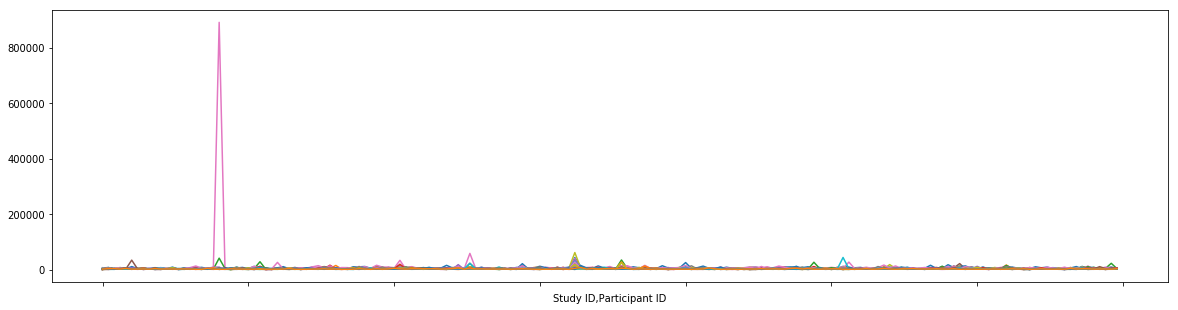

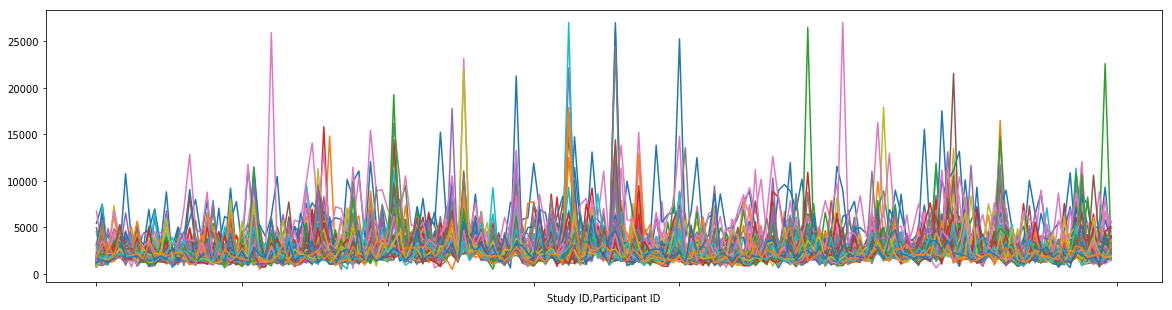

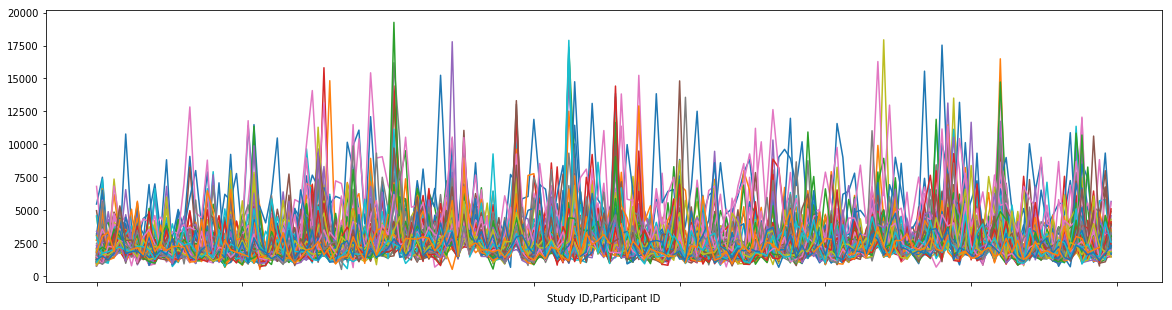

In [7]:
def plot_times(d):
    times = pd.DataFrame(d, columns=["ix", "Study ID", "Participant ID", "Test ID", "Test type", "Response time"])
    times["ix"] = times.groupby(["Study ID", "Participant ID"]).cumcount()
    del times["Test ID"]
    del times["Test type"]
    times.set_index(["Study ID", "Participant ID", "ix"], inplace=True)
    times = times.unstack("ix")
    times.plot(figsize=(20, 5), legend=False)

# plot times for all responses incl. outliers

plot_times(d)

# plot times for all responses without outliers

plot_times(dwo)

# plot times for all responses with less outliers

plot_times(dwo2)